In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# to verify implementation
from sklearn.linear_model import LinearRegression

import scipy

# Bayesian
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


# Load data

In [7]:
exercise = pd.read_csv('data/exercise.csv')
calories = pd.read_csv('data/calories.csv')

In [12]:
print(exercise.head())
print(exercise.describe())

    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8
            User_ID           Age        Height        Weight      Duration  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     42.789800    174.465133     74.966867     15.530600   
std    2.872851e+06     16.980264     14.258114     15.035657      8.319203   
min    1.000116e+07     20.000000    123.000000     36.000000      1.000000   
25%    1.247419e+07     28.000000    164.000000     63.000000      8.000000   
50%    1.499728e+07     39.000000    175.000000     74.000000     16.000000   
75%

In [13]:
print(calories.describe())

            User_ID      Calories
count  1.500000e+04  15000.000000
mean   1.497736e+07     89.539533
std    2.872851e+06     62.456978
min    1.000116e+07      1.000000
25%    1.247419e+07     35.000000
50%    1.499728e+07     79.000000
75%    1.744928e+07    138.000000
max    1.999965e+07    314.000000


In [17]:
df = pd.merge(exercise, calories, on = 'User_ID')
df['Intercept'] = 1
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


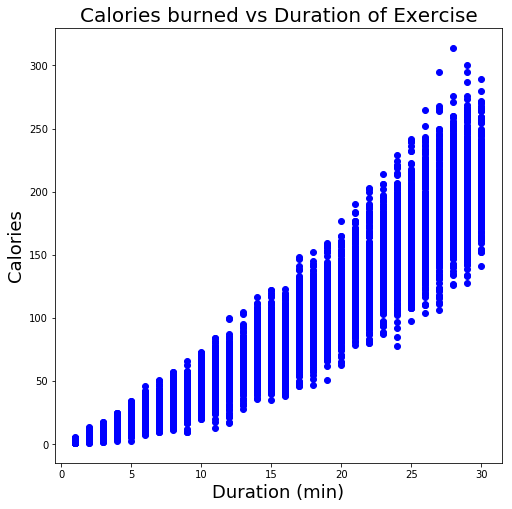

In [18]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [26]:
# find and remove outliers
mean = df['Calories'].mean()
std = df['Calories'].std()
df['Z_score']= (df['Calories'] - mean)/std 
reg_data = df[df.Z_score <= 3]

In [28]:
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']

In [34]:
lr = LinearRegression()
lr.fit(X.Duration.values.reshape(-1, 1), y)

print("Coefficient of Duration on Calories:" + str(lr.coef_[0]))
print("Intercept:" + str(lr.intercept_))

Coefficient of Duration on Calories:7.172883837907476
Intercept:-21.859656399672517


Bayesian Linear Regression

In [61]:
# Model with 500 observations
with pm.Model() as linear_model_500:
    # add to the model
    
    # priors for unknown model parameters
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    # can denote a vector of size > 1, but for this problem, we just have one x variable
    slope = pm.Normal('slope', mu = 0, sd = 10)
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    # can create new random variables from these
    
    # Expected value of outcome
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # Likelihood (sampling distribution) of outcomes/observed stochastic
    # parameters for the normal distribution are not fixed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # maximum a posteriori
    # map estimate is not always reasonable, especially when mode is extreme
    # of little use in most scenarios - because no estimate of uncertainty
    # map_estimate = pm.find_MAP(model=linear_model_500)
    # print(map_estimate)
    
    # Sampler
    # step method that coresponds to a Markov chain Monte Carlo algorithm
    # in this case, no u-turn sampler
    # can also be assigned automatically based on variable attributes
    # NUTS is most capable and especially useful with many continuous variables
    # It takes advantage of information about where regions of higher probability are,
    # based on the gradient of the log posterior-density.
    # matrix gives a rough distribution so it doesn't make too large or small jumps
    step = pm.NUTS()

    # Posterior distribution
    linear_trace_500 = pm.sample(1000, step, tune = 1000)
    # higher probability of acceptance isn’t always better because too high 
    # would imply bad exploration of the posterior space
    # warning of higher acceptance rate than 0.8 is not a huge deal, but to be safe
    # increase tuning

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 418.39draws/s]


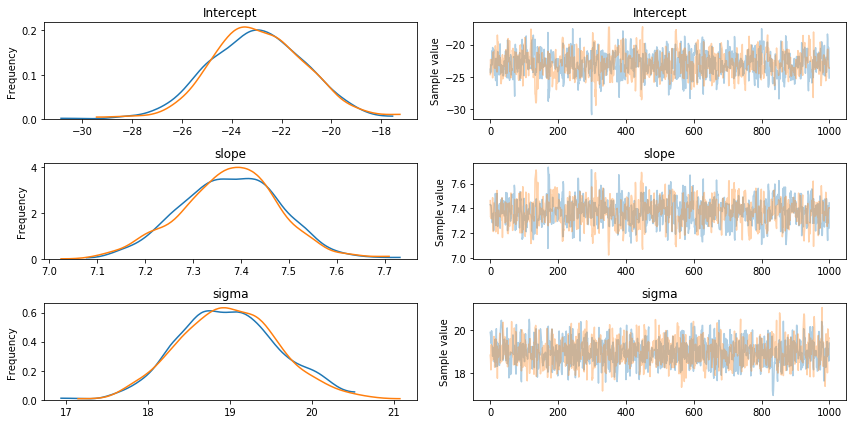

In [62]:
pm.traceplot(linear_trace_500);
# left: smoothed histogram of the marginal posteriors of the stochastic variables
# right = samples of markov chain in order

In [63]:
pm.summary(linear_trace_500).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-22.97,1.9,0.07,-26.43,-19.18,717.74,1.0
slope,7.38,0.1,0.00,7.16,7.56,812.83,1.0
sigma,18.98,0.6,0.02,17.91,20.24,1228.58,1.0


In [64]:
linear_trace_500.mean_tree_accept.mean()

0.8523029868849976

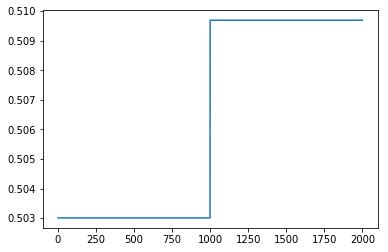

In [65]:
# to choose a tuning length
plt.plot(linear_trace_500['step_size_bar'])

In [66]:
# If there are many diverging samples, 
# this usually indicates that a region of the posterior has high curvature. 
print(any(linear_trace_500.diverging))

False


In [67]:
linear_trace_500.tree_size
# Tree size can be large: This can for example happen 
# if there are strong correlations in the posterior, 
# if the posterior has long tails, if there are regions of high curvature (“funnels”), 
# or if the variance estimates in the mass matrix are inaccurate. 
# Reparametrisation of the model or estimating the posterior variances from past samples might help.

array([7., 3., 3., ..., 7., 7., 3.])

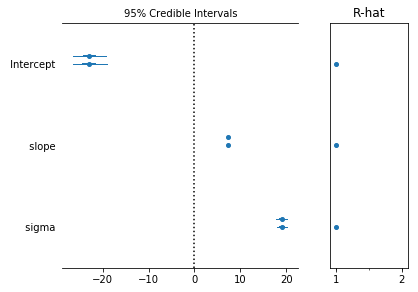

In [68]:
pm.forestplot(linear_trace_500);

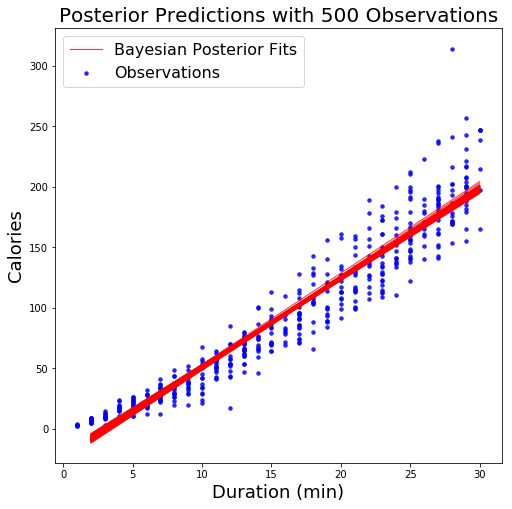

In [69]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.title('Posterior Predictions with 500 Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [72]:
# all observations
with pm.Model() as linear_model:
    
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    slope = pm.Normal('slope', mu = 0, sd = 10)
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    mean = intercept + slope * X['Duration']
    
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    step = pm.NUTS()

    linear_trace = pm.sample(1000, step, tune = 1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 2 chains:  32%|███▏      | 1277/4000 [00:09<00:16, 160.39draws/s]/usr/local/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Sampling 2 chains: 100%|██████████| 4000/4000 [00:24<00:00, 166.30draws/s]


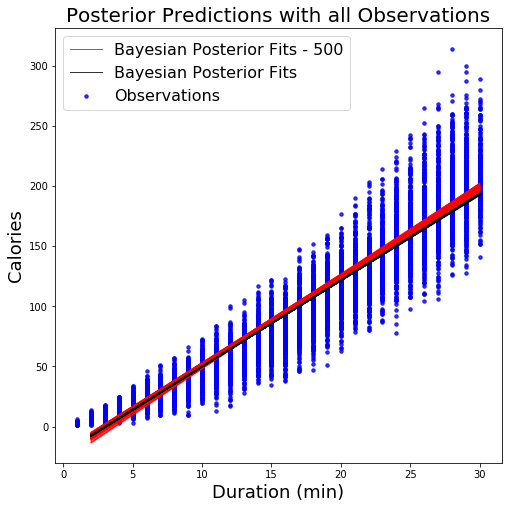

In [77]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits - 500',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x)
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'black', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

# Predictions

OLS prediction: 89.32004308789337


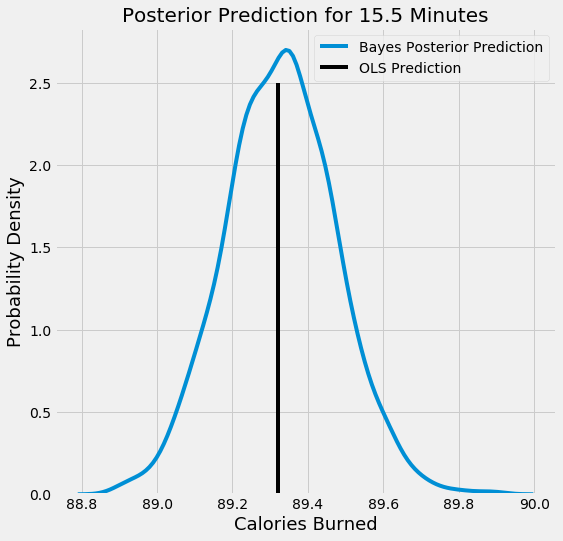

In [87]:
minutes = 15.5
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * minutes
ols = lr.intercept_ + lr.coef_[0] * minutes
print("OLS prediction: " + str(ols))

plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = ols, ymin = 0, ymax = 2.5, label = "OLS Prediction")
plt.legend()
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for ' + str(minutes) + ' Minutes', size = 20);